## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# План

В связи с запросами заказчика перед нами стоит задача регрессии. Соответственно, нам необходимо осуществить первичный анализ временного ряда и подготовку признаков для подачи в модель

## <a id='start'>Contents</a>

### [Preparing stage](#prepare)


### [Analytical stage](#analysis)

* [Проверка стационарности](#Diki-Fuller)

* [Автокорреляция](#correlation)

* [Сезонность](#seasonality)

### [Learning stage](#learning)

* [Генерация дополнительных признаков](#features)

* [Кроссвалидация](#cross)

* [Финальное обучение](#learning_f)

### [Testing stage](#test)

* [Сравнительная таблица](#comparison)

* [Визуализация CatBoost](#vision)

* [Выводы](#learning_f)

# <a id='prepare'>1. Подготовка</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#from pandas_profiling import ProfileReport
from tqdm import tqdm

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Проверим монотонность

In [3]:
print('Временной ряд непрерывный?', df.index.is_monotonic)

Временной ряд непрерывный? True


### Построим первичный график временного ряда для одной недели:

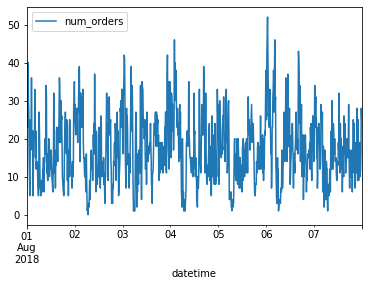

In [4]:
df['2018-08-01':'2018-08-07'].plot()

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>Данные на базе) ОК.

# <a id='analysis'>2. Анализ</a>

**Вводные:**

Нам доступны данные за 8 полных месяцев 2018-го года.

Необходимо предсказывать значения в течение следующего часа


#### В проведении анализа мы должны соблюсти несколько ступеней

1) Проверка на стационарность временного ряда 

2) Проверка зависимостей внутри временного ряда

3) Статистические методы исследования временных рядов

In [5]:
df = df.resample('1H').sum()

In [6]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize



### <a id='Diki-Fuller'>Тест Дики-Фуллера</a>

In [7]:

def test_stationarity(timeseries, window = 6):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value {}'.format(key)] = value
    print (dfoutput)

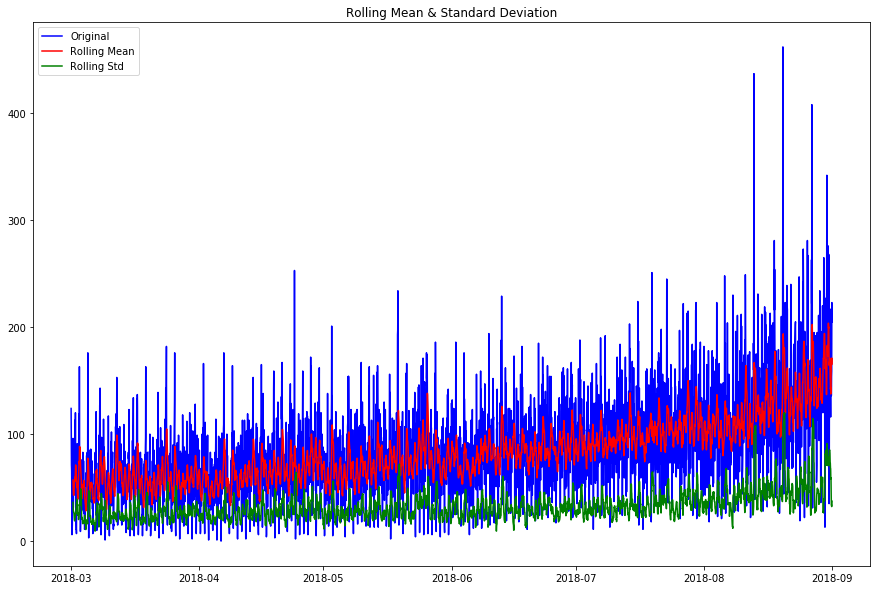

Results of Dickey-Fuller Test:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value 1%                -3.431842
Critical Value 5%                -2.862199
Critical Value 10%               -2.567121
dtype: float64


In [8]:
test_stationarity(df, 12)

Тест по критерию Дики-Фуллера показал, что с 95% мы можем утверждать, что временной ряд стационарен 
**(-3.06 < -2.86)**

В то же время наш график демонстрирует стабильную линию тренду на повышение. Среднее возрастает медленно, дисперсия колеблется ярко в районе выбросов значений вверх.


***Примечание: График для тестов был сглажен по 12 часам, что обеспечить возможность визуального восприятия***



<div style="background: #ffeeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
Есть три вида нестационарности: тренд, сезонность, непостоянство дисперсии)<br>
Стационарный ряд - это когда ничего из перечисленного в ряде не наблюдается (очистили его). Нужно это для одного из методов прогрнозироваия АРИМА, например. Для нашегго метода прогнозирования это понятие можно не использовать.<br>
    

### <a id='correlation'>Автокорреляция</a>

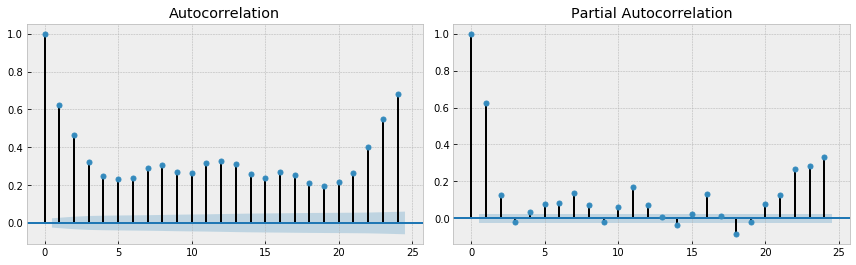

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.1)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.1)

        plt.tight_layout()
    return 

tsplot(df.num_orders, lags = 24)

По графику автокорреляции мы видим, что каждое последующее значение достаточно хорошо согласуется с предыдущим.

**Посмотрим на показатели при вычитании предыдущего значения из текущего.**

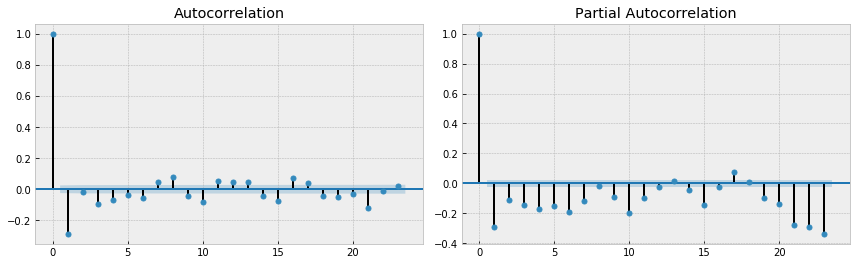

In [10]:
df['num_diff'] = df.num_orders - df.num_orders.shift(1)

tsplot(df.num_diff[24+1:], lags = 23)

Автокорреляция почти "ушла в ноль" для величины остатков каждого последующего шага от предыдущего. Это означает, что нам удалось привести величины в относительно предыдущего шага, значит наша гипотеза о стационарности ряда верна.

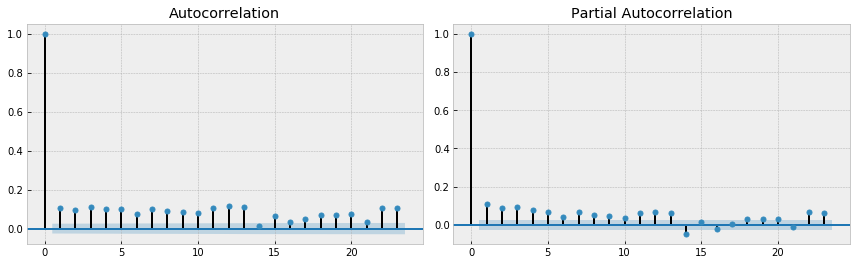

In [11]:
df['num_diff'] = df.num_orders - df.num_orders.shift(168)

tsplot(df.num_diff[24*7+1:], lags = 23)

Так наблюдаем



### <a id='seasonality'>Сезонность</a>

***Проведем декомпозицию временного ряда и посмотроим график для 3-х дней в середине ряда:***

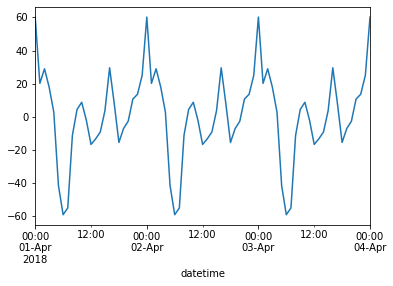

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposed = seasonal_decompose(df.num_orders)


decomposed.seasonal['2018-04-01-00':'2018-04-04-00'].plot()

Есть ли ещё какие-то колебания? Построим график для значений в пределах месяца:

Итак, мы видим, что ряд точно обладает сезонностью в течение одних суток:

Локальные минимумы в рамках суток расположены ранним утром, обеденное время, вечером (~18 часов)

Локальные максимумы расположены в ~10-11 часов, 17 часов и в полуночь.


***На данном этапе мы должны принять решение, отказываемся ли мы от построения статистисческой модели или нет (Хольт-Уинтерс, SARIMA). По нашему мнению, эффективнее сделать хорошие фичеры и перевести задачу в задачу регрессии***



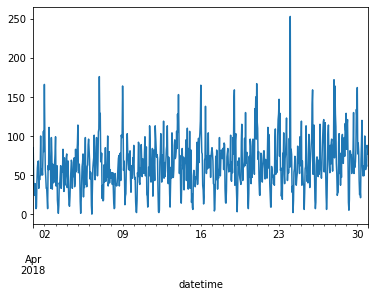

In [13]:
df.loc['2018-04-01':'2018-04-30','num_orders'].plot()

Действительно, есть ещё колбания количества заказов в течение одной недели.

Больше всего заказов скорее всего приходится в пятницу и в воскресенье.

Нетипичное значение около 23 апреля может быть выбросом, связанным с каким-либо мероприятие и повышенным спросом на такси в тот день

Итоги:

1) Ряд обладает плавно повышающимся трендом увеличения среднего количества заказов в сутки на протяжении года неизвестной природы - недостаточно данных

2) Ряд обладает преимущественно внутрисуточной сезонностью своих значений, недельная сезонность также наблюдается

3) Ряд достаточно детерменирован своим предыдущими значениями

4) Тест Дики-Фуллера выявил признаки постоянства (среднего и дисперсии), несмотря на выше перечисленные характеристики ряда

# <a id='learning'>3. Обучение</a>

Избавимся от признака, который мы построили для автокорреляции, так как он дает нам "взгляд в будущее"

***Также нам нужно сгенерировать фичеры для обучения, а так как у нас абсолютный ряд скоррелирован с предыдущим значением и обладает сезонностью, данные фичеры должны отражать абсолютное положение на часах, предыдущие значения, лаги и т.п.***

In [14]:
df = df.drop('num_diff', axis=1)

### <a id='features'> Генерация дополнительных признаков</a>



#### Date-features



In [15]:
#df['month'] = df.index.month
#df['day'] = df.index.day
df['weekday'] = df.index.dayofweek
df['hour'] = df.index.hour



#### Lag-features

*Зададим лаг по 48 часам включительно:*

In [16]:
for i in range(1,49):
    
    df[f'lag_{i}'] = df.num_orders.shift(i)

#### Window-mean-features

*Зададим окно среднего по 2,4,6 часам и так далее до 24*

In [17]:
for i in range(2,25, 2):
    
    df[f'rolling_{i}'] = df.num_orders.shift(1).rolling(i).mean()

In [18]:
df = df.dropna()

In [19]:
df.head()

,num_orders,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,rolling_6,rolling_8,rolling_10,rolling_12,rolling_14,rolling_16,rolling_18,rolling_20,rolling_22,rolling_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,5,0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,87.166667,86.000,79.1,72.666667,72.642857,69.2500,62.555556,57.85,58.909091,62.750000
2018-03-03 01:00:00,108,5,1,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,99.500000,96.125,91.0,83.250000,80.428571,76.5625,71.000000,65.00,62.909091,65.791667
2018-03-03 02:00:00,25,5,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,109.333333,99.250,95.9,88.500000,81.642857,80.5000,76.611111,69.85,64.909091,65.291667
2018-03-03 03:00:00,64,5,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,98.000000,91.250,90.2,86.916667,80.857143,78.6875,75.444444,70.55,65.136364,63.208333
2018-03-03 04:00:00,44,5,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,91.833333,93.125,88.3,87.333333,82.214286,77.0000,76.500000,73.40,67.545455,63.208333


In [20]:
df.shape

(4368, 63)

### Пойдем учить

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop('num_orders', axis=1)

y = df['num_orders']



In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.1)

print(X_train.shape, y_train.shape)
print()
print(X_test.shape, y_test.shape)

(3931, 62) (3931,)

(437, 62) (437,)


## <a id='cross'>Cross-validation TimeSeries</a>

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import time

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [24]:
cbr =CatBoostRegressor(random_state=42, iterations = 100, verbose=False)
tree = DecisionTreeRegressor(random_state=42)
lr = LinearRegression()

In [25]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    
    print('Тестируем модель: ',model.__class__.__name__)
    print('Размер train_set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Размер каждого фолда: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # цикл перебора разбиений   
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Разбиваем ' + str(i) + ' кусочки как ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # Размер должен быть k*i

        index = int(np.floor(X.shape[0] * split))

        # Фолды для трейна        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # Фолд для теста
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = np.sqrt(metrics(model.predict(X_testFold), y_testFold))
    # функция вернет среднее значение метрики
    return errors.mean()

In [26]:
#models = [lr, tree]

performTimeSeriesCV(X_train, y_train, 5, lr, mean_squared_error)

Тестируем модель:  LinearRegression
Размер train_set: (3931, 62)
Размер каждого фолда: 786

Разбиваем 2 кусочки как 1/2
Size of train + test: (1572, 62)

Разбиваем 3 кусочки как 2/3
Size of train + test: (2358, 62)

Разбиваем 4 кусочки как 3/4
Size of train + test: (3144, 62)

Разбиваем 5 кусочки как 4/5
Size of train + test: (3930, 62)


24.95924005727999

**На кроссвалидации с нашими признаками удалось достичь среднего значения метрики RMSE в 31 единицу заказов**

Проверим дерево:

In [27]:
performTimeSeriesCV(X_train, y_train, 5, tree, mean_squared_error)

Тестируем модель:  DecisionTreeRegressor
Размер train_set: (3931, 62)
Размер каждого фолда: 786

Разбиваем 2 кусочки как 1/2
Size of train + test: (1572, 62)

Разбиваем 3 кусочки как 2/3
Size of train + test: (2358, 62)

Разбиваем 4 кусочки как 3/4
Size of train + test: (3144, 62)

Разбиваем 5 кусочки как 4/5
Size of train + test: (3930, 62)


34.96449226857621

**Дерево показало себя хуже, теперь посмотрим на CatBoostRegressor**

In [28]:
performTimeSeriesCV(X_train, y_train, 5, cbr, mean_squared_error)

Тестируем модель:  CatBoostRegressor
Размер train_set: (3931, 62)
Размер каждого фолда: 786

Разбиваем 2 кусочки как 1/2
Size of train + test: (1572, 62)

Разбиваем 3 кусочки как 2/3
Size of train + test: (2358, 62)

Разбиваем 4 кусочки как 3/4
Size of train + test: (3144, 62)

Разбиваем 5 кусочки как 4/5
Size of train + test: (3930, 62)


26.28932502500426

### Результаты кросс-валидации

Имеем 2 модели-кандидата для того, чтобы продолжить обучение и протестировать на наших данных.

- LinearRegression

- CatBoostRegressor

Обе на дефолтных параметрах показали себя очень хорошо и достигли значения ниже целевого (однако пока не на тесте)

***Примечание: имеет смысл попробовать ещё случайный лес, однако он долго учится и градиентный бустинг был бы эффективнее в решений задачи прогнозирования временных рядов. Поэтому только 2 модели попадают далее***


## <a id='learning_f'>Финальное обучение</a>

In [29]:
categorical_features = np.where(X.dtypes != np.float)[0]

cbr_f = CatBoostRegressor(loss_function='RMSE', depth=3, learning_rate=0.3, iterations=1000, 
    random_seed=18, 
    od_type='Iter',
    od_wait=20,
    verbose = 100                      
)



In [30]:
start = time.time()

cbr_f.fit(
    X_train, y_train, #use_best_model=True,
    cat_features=categorical_features,
    #eval_set=(X_val, y_val),
    verbose=50
)

cb_time = time.time()

0:	learn: 34.6033295	total: 3.66ms	remaining: 3.65s
50:	learn: 20.8891889	total: 1.18s	remaining: 21.9s
100:	learn: 18.8403950	total: 2.45s	remaining: 21.8s
150:	learn: 17.5848653	total: 3.64s	remaining: 20.5s
200:	learn: 16.4300106	total: 4.83s	remaining: 19.2s
250:	learn: 15.5677321	total: 6.09s	remaining: 18.2s
300:	learn: 14.7141753	total: 7.27s	remaining: 16.9s
350:	learn: 13.9716504	total: 8.55s	remaining: 15.8s
400:	learn: 13.2825645	total: 9.82s	remaining: 14.7s
450:	learn: 12.6880891	total: 11s	remaining: 13.4s
500:	learn: 12.1611644	total: 12.2s	remaining: 12.1s
550:	learn: 11.5611361	total: 13.4s	remaining: 10.9s
600:	learn: 11.1024219	total: 14.6s	remaining: 9.72s
650:	learn: 10.6955380	total: 15.8s	remaining: 8.48s
700:	learn: 10.2379742	total: 17s	remaining: 7.25s
750:	learn: 9.8738885	total: 18.2s	remaining: 6.03s
800:	learn: 9.5704628	total: 19.5s	remaining: 4.83s
850:	learn: 9.2215828	total: 20.6s	remaining: 3.61s
900:	learn: 8.8354856	total: 21.9s	remaining: 2.41s
950

In [31]:
lr_f = LinearRegression()



In [32]:
start = time.time()

lr_f.fit(X_train, y_train) 

lr_time = time.time() - start

# <a id='test'>4. Тестирование</a>

Теперь настал самый важный момент оценка качества работы моделей по метрикам, времени обучения, времени предсказания.

Запишем в массивы результаты работы наших моделей, а потом выведем в табличной форме:

In [33]:
models = [cbr_f, lr_f]


time_fit = [cb_time, lr_time]

pred_dict = dict()

time_pred, rmse, mae, r2 = [],[],[],[]

for model in models:
    start = time.time()
    predictions = model.predict(X_test)
    pred_time = time.time() - start
    
    time_pred.append(pred_time)
    
    pred_dict[model.__class__.__name__] = predictions
    
    rmse_1 = np.sqrt(mean_squared_error(y_test,predictions))
    rmse.append(rmse_1)
    
    mae_1 = mean_absolute_error(y_test,predictions)
    mae.append(mae_1)
    
    r2_1 = r2_score(y_test,predictions)
    r2.append(r2_1)
    


### <a id='comparison'>Сравнительная таблица результатов</a>

In [34]:
checker = pd.DataFrame(index = [model.__class__.__name__ for model in models])

checker['time_fit'] = time_fit
checker['time_pred'] = time_pred
checker['rmse'] = rmse
checker['mae'] = mae
checker['R2-Score'] = r2

checker

,time_fit,time_pred,rmse,mae,R2-Score
CatBoostRegressor,1.606105e+09,0.099671,44.471298,33.719979,0.428061
LinearRegression,3.427577e-02,0.001390,42.009698,31.089996,0.489626


Из данной таблицы четко видно, что CatBoost значительно уступает по времени обучения и выполнения предсказаний, однако он существенно превосходит линейную регрессию по качеству предсказаний на тестовой выборке. 

## <a id='vision'> Визуализация предсказаний </a>


Визуализируем результаты на графике

In [35]:
def visualize_cb(model,):
    prediction_train = model.predict(X_train)
    plt.figure(figsize=(15, 5))
    plt.title("Тренировочные предсказания " + model.__class__.__name__)

    plt.plot(list(y_train), color = 'blue')
    plt.plot(prediction_train, color = 'orange')
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = pred_dict[model.__class__.__name__]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction", color = 'blue')
    plt.plot(list(y_test), label="y_test", color = 'orange')
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Тестовые предсказания " + model.__class__.__name__)
    plt.grid(True)
    plt.legend()
    
    plt.show()

### Визуализация Линейная регрессия

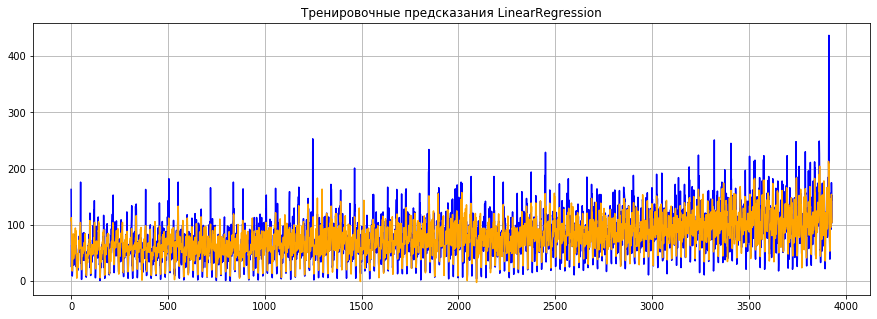

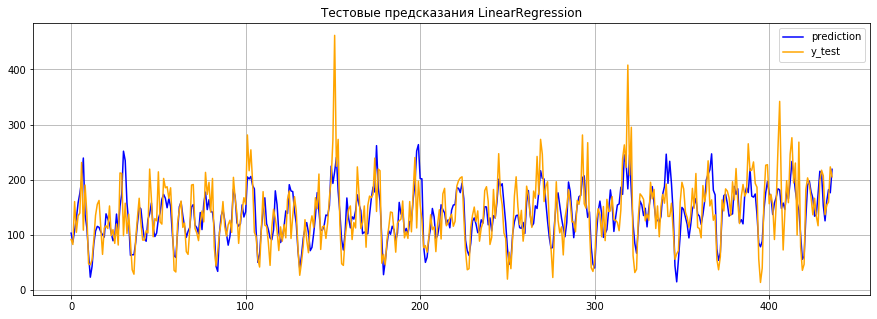

In [36]:
visualize_cb(lr_f)

### Визуализация катбуст

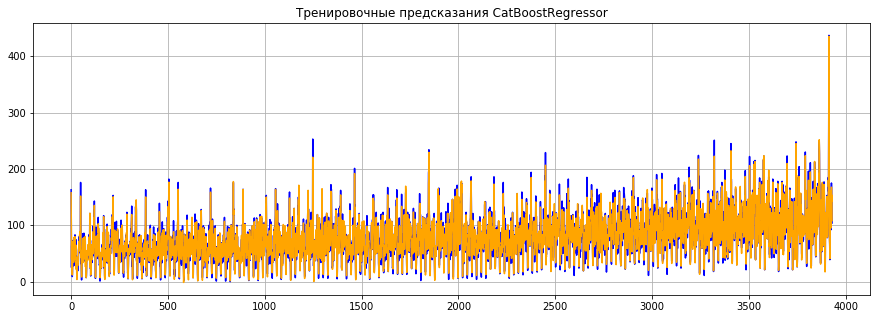

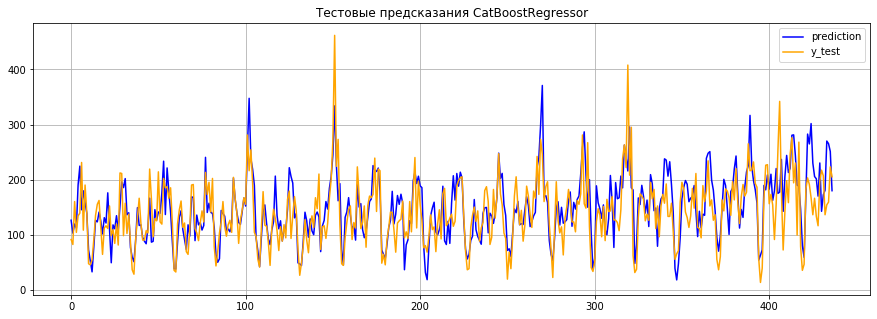

In [37]:
visualize_cb(cbr_f)

Наша модель поймала аномальные значения и приняла их за паттерны поведения временного ряда.

В целом она отображает динамику величины, хотя иногда завышать оценки спроса и реже - существенно занижать

### <a id='summary'>Выводы</a>

В процессе работы мы сделали много важных вещей:

- Мы изучили данные и убедились в нормальных показателях стационарности ряда заказов, а также в показателях автокорреляции. Ряд приближен к стационарному на уровне p-value: 0.05, имеется автокорреляция значений

- Построили временные признаки, а также признаки отставания и скользящего среднего для нашей модели

- Апробировали 3 модели и провели кросс-валидацию по k-fold

- Обучили 2 модели на тестовой выборке, построили сравнительную таблицу качества предсказаний, а также визуализировали результаты работы одной из моделей (Catboost)

- Достигли целевой метрики качества в 45 rmse при помощи модели градиентного бустинга (CatBoostRegressor) и 42 rmse при помощи линейной регрессии

- ***Таким образом, мы останавливаемся на модели простой линейной регрессии***


В целом, хотелось бы порекомендовать в дальнейшем попробовать модель SARIMA, от который мы отказались из-за сложности её построения, а также разобраться с отсутствие поддержки библиотек tsfresh & fbprophet.


[<center>В начало</center>](#start)